# Background and Context:

Twitter possesses 330 million monthly active users, which allows businesses to reach a broad population and connect with customers without intermediaries. On the other hand, there’s so much information that it’s difficult for brands to quickly detect negative social mentions that could harm their business.

That's why sentiment analysis/classification, which involves monitoring emotions in conversations on social media platforms, has become a key strategy in social media marketing.

Listening to how customers feel about the product/service on Twitter allows companies to understand their audience, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry

## Data Description:

A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

## Table of Contents

- Importing Libraries
- Data Overview
- Initial Exploratory Data Analysis
- Data Pre-Processing
- Secondary Exploratory Data Analysis
- Vecotrization
- Model Building
  - Count Vectorizer
    - SMOTE and RUS
  - TF-IDF Vectorizer
- Model Evaluation
  - Word Cloud of Top 40 Features
- Conclusion and Key Insights

# Importing Libraries

In [1]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import re, string, unicodedata                                           #Used for Text PreProcessing
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt                                          # Used for plotting
import seaborn as sns                                                    # Used for plotting
from collections import Counter                                          # count the key-value pairs in an object

import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator          # Used for plotting the wordcloud of a corpus
import nltk                                                              # Used for different task of NLP
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
import contractions                                                      # Helps in expansion of contracted words
from nltk.corpus import stopwords                                        # Used for removal of stop words
from nltk.stem.porter import PorterStemmer                               # Used for Stemming of words in the corpus
from nltk.stem.wordnet import WordNetLemmatizer                          # Import Lemmatizer.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# Libraries for Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier

# Libraries to split data and obtain metric scores
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    plot_confusion_matrix,
    classification_report
)

# Libraries for Model Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Libraries for Over and Under Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data Overview

In [3]:
# Mounting gdrive
from google.colab import drive
drive.mount('/content/gdrive')

# Reading in the data
data = pd.read_csv('/content/gdrive/MyDrive/Education/Data Science/Colab Notebooks/AIML - PGP/Projects/Tweets.csv')
df = data.copy()

# Viewing the shape of the data
df.shape

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(14640, 15)

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


There are 14640 rows of data across 15 columns. The tweet_id column can be removed since it is a unique identifier and not necessary for this analysis. Retweet count appears to have significant amount of 0's.

In [5]:
df.drop('tweet_id', axis = 1, inplace = True)

In [6]:
df.retweet_count.value_counts()

0     13873
1       640
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
28        1
9         1
18        1
11        1
31        1
15        1
44        1
Name: retweet_count, dtype: int64

Since the vast majority of the data has no retweets, there is not much meaningful data here. We can safely remove this information from the dataframe.

In [7]:
df.drop('retweet_count', axis = 1, inplace = True)

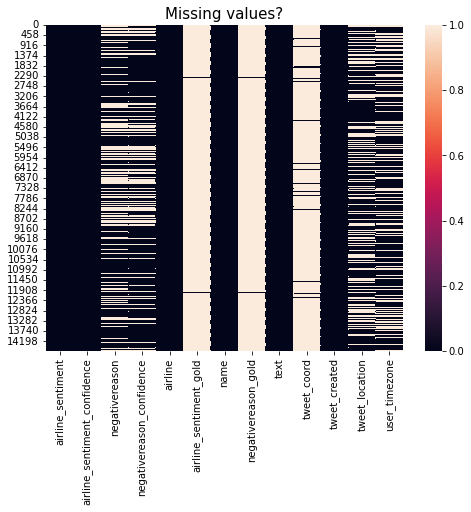

In [8]:
# Looking at the missing data
plt.figure(figsize=(8,6))
sns.heatmap(df.isnull())                                  
plt.title("Missing values?", fontsize = 15)
plt.show()

- Airline_sentiment_gold and negativereason_gold are missing all data
- Tweet_coord is missing almost all of its data
- Negative reason, negative reason confidence, tweet location, and user timezone are all missing a significant portion of data

In [9]:
def missing_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)                                            # Nu of zero in each column
        mis_val = df.isnull().sum()                                                                #Missing value in each column
        mis_val_percent = 100 * df.isnull().sum() / len(df)                                        #Missing value percent accross column
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)                         #Concatenation of above aoutput
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})               #Renaming of each coumn
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']  #column having total of zero value and missing values
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df) # Column having percentage of totalof zero and missing value
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(                                                     #Selecting and sorting those column which have at not a zero value in % of Total Values column
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [10]:
missing_values_table(df)

Your selected dataframe has 13 columns and 14640 Rows.
There are 7 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
negativereason_gold,0,14608,99.8,14608,99.8,object
airline_sentiment_gold,0,14600,99.7,14600,99.7,object
tweet_coord,0,13621,93.0,13621,93.0,object
negativereason,0,5462,37.3,5462,37.3,object
user_timezone,0,4820,32.9,4820,32.9,object
tweet_location,0,4733,32.3,4733,32.3,object
negativereason_confidence,1344,4118,28.1,5462,37.3,float64


- The table confirms our previous observations
- Due to the large amount of data missing from the negativereason_gold, airline_sentiment_gold, and tweet_coord, we'll remove them from the dataframe as we have no we of correctly interpolating that information

In [11]:
df.drop(['negativereason_gold', 'airline_sentiment_gold', 'tweet_coord'], axis = 1, inplace = True)

In [12]:
# Extracting time information from tweets_created
year=[]
month=[]
date=[]
hour=[]
for x in df['tweet_created']:
    year.append(int(x.split("-")[0]))                                          
    month.append(int(x.split("-")[1]))                                         
    date.append(int(x.split("-")[2].split(" ")[0]))                            
    hour.append(int(x.split("-")[2].split(" ")[1].split(":")[0]))

df['year']=year
df['month']=month
df['dates']=date
df['hour']=hour
df.drop('tweet_created', axis = 1, inplace = True)
df.sample(n=5)

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,text,tweet_location,user_timezone,year,month,dates,hour
4302,negative,1.0,Can't Tell,1.0000,United,kat_volk,.@united nothing apparently. I've flown w/ you...,"Tucson, AZ and Vancouver, BC",Arizona,2015,2,17,8
7462,negative,1.0,Lost Luggage,0.6932,Delta,emilybholan,@JetBlue I waited 3 hrs for my bags and my fli...,N Y,NaN,2015,2,22,11
9383,negative,1.0,Lost Luggage,0.6494,US Airways,Taryn_Sunstrom,@USAirways you guys Cancelled Flightled two of...,The Shire,Atlantic Time (Canada),2015,2,23,12
12739,negative,1.0,Can't Tell,1.0000,American,Amrutafrika,@AmericanAir are you guys intentionally trying...,NaN,NaN,2015,2,23,18
9521,negative,1.0,Cancelled Flight,0.6373,US Airways,eozonian,@USAirways rebooked for Tuesday. Arriving too ...,TLH,NaN,2015,2,23,8


# Exploratory Data Analysis

In [13]:
# Function for histogram and boxplot distribution comparison
def hist_box(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="r"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [14]:
# Function to create labeled barplots
def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

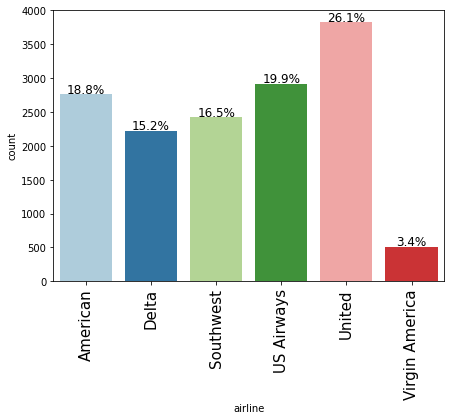

In [15]:
# Viewing distribution of airlines within the data
labeled_barplot(df, 'airline', perc=True)

- United has the 26.1% of all the tweets
- Virgin America has only 3.4% of all tweets
- All other airlines recieve between 15%-19% of all tweets

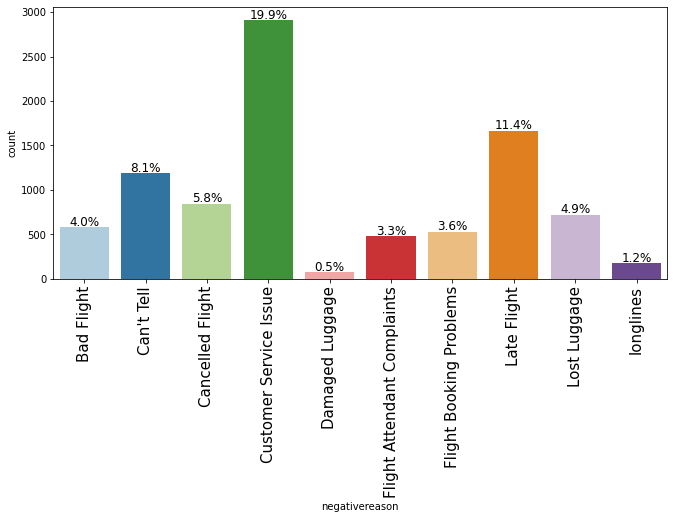

In [16]:
# Viewing distribution of complaints within the data
labeled_barplot(df, 'negativereason', perc=True)

- Customer Service Issues are the biggest reason for a negative sentiment at 20%
    - The next closest is a late flight at 11.4%
- Damaged Luggage is the smallest reason for negative sentiment at 0.5%
    - This is followed closely by long lines at 1.2%
- 8% of the negative reasons are labeled can't tell, i.e the reason is unknown.

In [17]:
# Setting colwidth to none so full text is viewable
pd.set_option('display.max_colwidth', None)
print(df[df['negativereason'] == "Can't Tell"]['text'].sample(n=3))

14077                                            @AmericanAir well done, you have taken the fun out of air travel @PHLAirport
3668     @united now we are trying to get to San Juan from Chicago O'Hare. Having lots of problems. May get a standby flight.
6734                 @SouthwestAir why have you guys jacked up the prices AFTER you said prices were going to be lowered? SMH
Name: text, dtype: object


We can see that the can't tell reason is aptly named. Some tweets are intelligble and could potentially be recategorized, but overall most of them are just generally negative with no specific reason as to why.

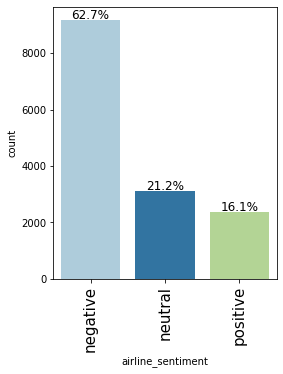

In [18]:
# Visualizing the overall distribution of sentiment
labeled_barplot(df, 'airline_sentiment', perc=True)

- The vast majority of tweets (63%) are negative in sentiment
- 21% are neutral
- 16% are positive

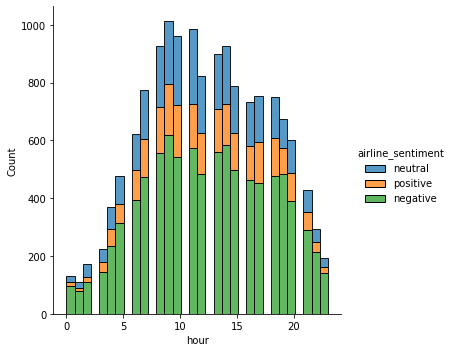

In [19]:
# Visualizing sentiment distribution over time of day
sns.displot(data=df, x='hour', hue='airline_sentiment', multiple='stack');

The overall distribution of sentiment remains roughly the same hour to hour. As one might expect, the majority of tweets are concecentrated during the middle of the day and evening when most flights are occuring.

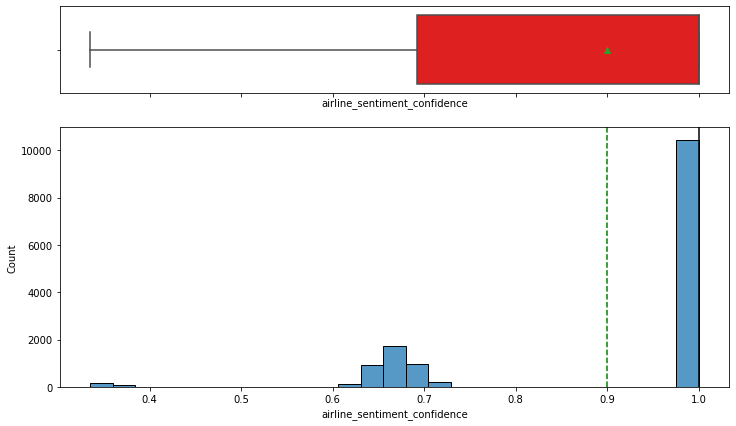

In [20]:
hist_box(df, 'airline_sentiment_confidence')

Vast majority of tweets have a sentiment confidence of 70% or higher

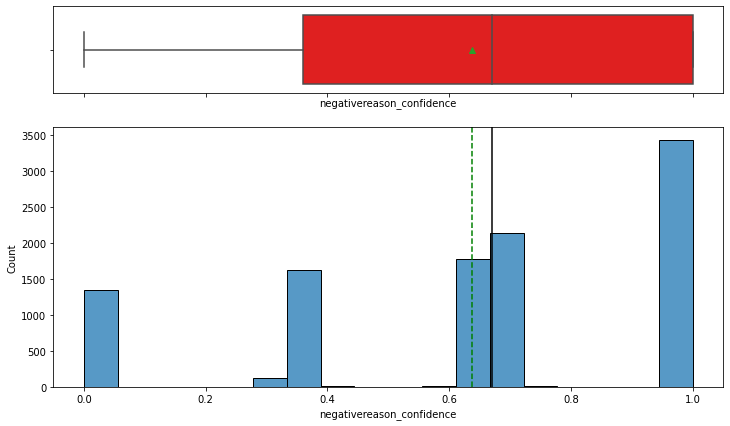

In [21]:
hist_box(df, 'negativereason_confidence')

The confidence in the negative reason is more equally distributed. Majority of the confidence is 60% or above.

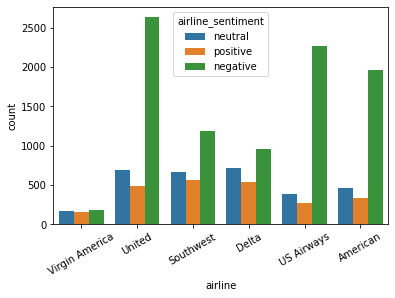

In [22]:
# Visualizing the distribution of sentiment by airline
sns.countplot(data=df, x='airline', hue='airline_sentiment')
plt.xticks(rotation = 30);

The proportion of sentiment appears to be the same across all airlines (except Virigin America)

In [23]:
# Creating individual dataframe for each sentiment type
df_pos = df[df['airline_sentiment'] == 'positive']
df_neg = df[df['airline_sentiment'] == 'negative']
df_neu = df[df['airline_sentiment'] == 'neutral']

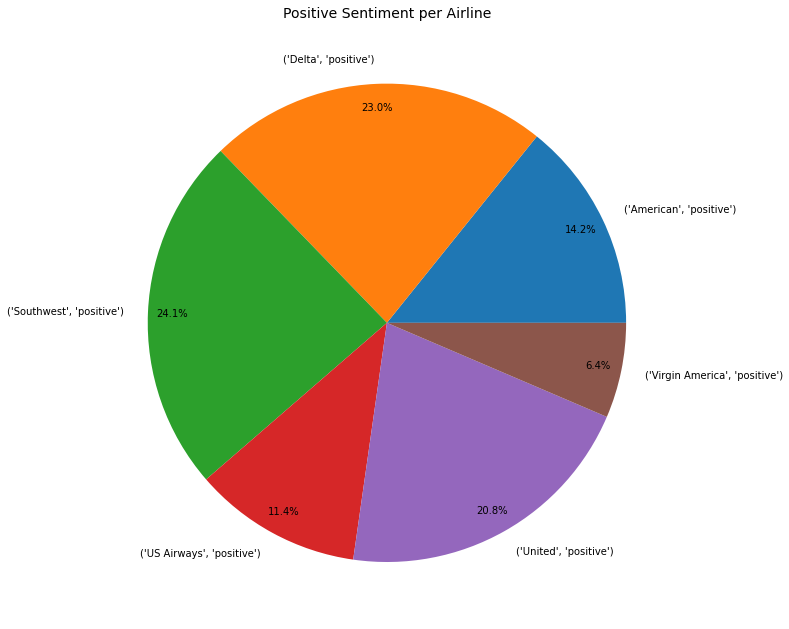

In [24]:
# Visualizing distribution of positive sentiment per airline
Category = df_pos.groupby('airline')['airline_sentiment'].value_counts()
pie, ax = plt.subplots(figsize=(20,11))
labels = Category.keys()
plt.pie(x=Category, autopct="%.1f%%", labels=labels, pctdistance=0.9)
plt.title("Positive Sentiment per Airline", fontsize=14);

- Southwest and Delta only make up 17% and 15% of all tweets, but receives 24% and 23% of all positive sentiment
- Virgin America recieves double the amount of positive tweets compared to its overall representation
- United America only receives 21% of all positive sentiment despite haveing almost a third of overall tweet representation

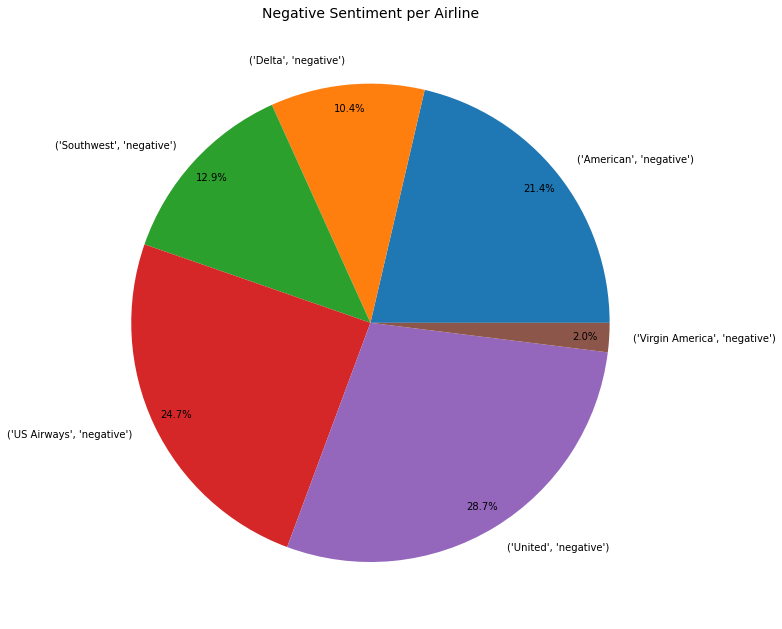

In [25]:
# Visualizing distribution of negative sentiment per airline
Category = df_neg.groupby('airline')['airline_sentiment'].value_counts()
pie, ax = plt.subplots(figsize=(20,11))
labels = Category.keys()
plt.pie(x=Category, autopct="%.1f%%", labels=labels, pctdistance=0.9)
plt.title("Negative Sentiment per Airline", fontsize=14);

- US Airways and United receive 53% of the negative sentiment while only possessing 45% of total tweet representation
- American recieves an equivalant share of negative sentiment to its tweet representation
- Southwest, Delta, and Virgin receive between 2%-4% less negative sentiment to their tweet representation

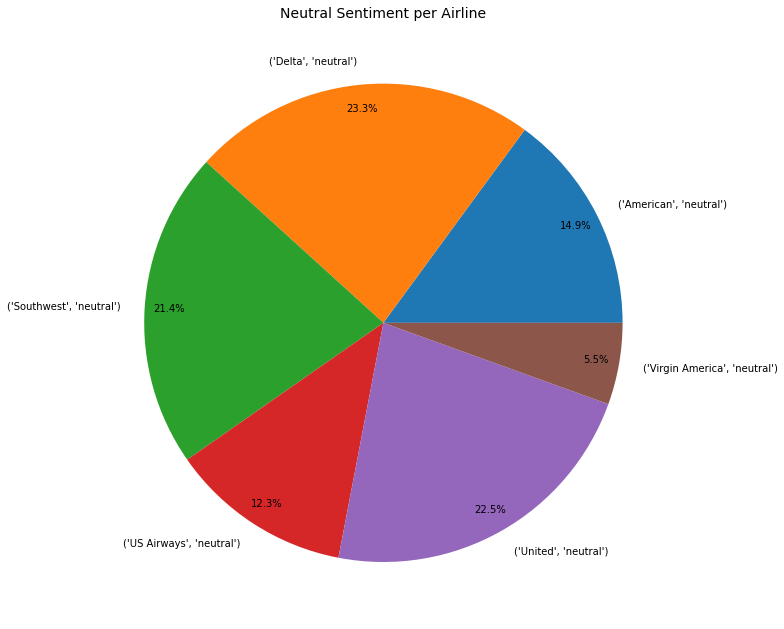

In [26]:
# Visualizing distribution of neutral sentiment per airline
Category = df_neu.groupby('airline')['airline_sentiment'].value_counts()
pie, ax = plt.subplots(figsize=(20,11))
labels = Category.keys()
plt.pie(x=Category, autopct="%.1f%%", labels=labels, pctdistance=0.9)
plt.title("Neutral Sentiment per Airline", fontsize=14);

- Delta holds 23.3% of neutral tweet sentiment with only 15.2% of total tweet representation
- Southwest holds 21.4% of nuetral tweet sentiment with only 16.5% of total tweet representation
- US Airways, United, and American both hold about 5% less representation with neutral tweets than with their total

# Data Pre-Processing

In [27]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = word.lower()           # Converting to lowercase
        new_words.append(new_word)        # Append processed words to new list.
    return new_words

def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)    # Append processed words to new list.
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []                        # Create empty list to store pre-processed words.
    stoplist = set(stopwords.words("english"))
    for word in words:
        if word not in stoplist:
            new_words.append(word)        # Append processed words to new list.
    return new_words

def lemmatize_list(words):
    new_words = []
    lemmatizer = WordNetLemmatizer()
    for word in words:
      new_words.append(lemmatizer.lemmatize(word))
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

In [28]:
# Removal of the http link using Regular Expression.
for i, row in df.iterrows():
    clean_tweet = re.sub(r"http\S+", "", df.at[i, 'text'])
    df.at[i,'text'] = clean_tweet
df['text'].sample(n=3)

4251    @united Nearly 48 hours Late Flightr and still no idea where it is. I will never fly United again if I can help it.
269                                                                              @VirginAmerica I see what you did there ;)
6749               @JetBlue They weren't on any flight, they just came Late Flight. Your JetBlue employee just informed us!
Name: text, dtype: object

In [29]:
# Removal of the numbers using Regular Expression.
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

df['text'] = df['text'].apply(lambda x: remove_numbers(x))
df['text'].sample(n=3)

11889                                                           @AmericanAir  seconds from touchdown at Madrid airport in April  #AvGeek 
12658    @AmericanAir Can I use an SWU on an Finnair codeshare of an American operated flight (JFK-MAN)?  Thanks in advance for the help!
8252                                                                                            @JetBlue thanks JB!! This is why I 💙 you!
Name: text, dtype: object

In [30]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [31]:
# Tokenization of data before normalization
df['text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
# Normalizing the data
df['text'] = df.apply(lambda row: normalize(row['text']), axis=1)
df['text'].sample(n=5)

10915    usairways thanks helping reflight booking problem cancelled flightedflight yvonne anthony help u get tel aviv time happyfriday
1668                                                                                             united finally made rep solved problem
11539                                                     usairways empty first class seat flight check would nt automatically upgraded
6851                                                                                                             jetblue great land jfk
8030                                                                       jetblue americanair ah ha misread end date thanks clarifying
Name: text, dtype: object

# Secondary Exploratory Data Analysis

In [32]:
# Finding the most common words in all tweets
df['text'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data
top = Counter([item for sublist in df['text'] for item in sublist])
freq = pd.DataFrame(top.most_common(20))
freq.columns = ['Common_words','count']
freq.style.background_gradient(cmap='Blues')

,Common_words,count
0,flight,4569
1,united,4161
2,usairways,3051
3,americanair,2962
4,southwestair,2461
5,jetblue,2395
6,nt,2080
7,get,1376
8,hour,1161
9,thanks,1080


Most common words is flight, followed by the various airline names.

In [33]:
# Recreating individual dataframe for each sentiment type now that text is normalized
df_pos = df[df['airline_sentiment'] == 'positive']
df_neg = df[df['airline_sentiment'] == 'negative']
df_neu = df[df['airline_sentiment'] == 'neutral']

In [34]:
# Most common positive words
top = Counter([item for sublist in df_pos['text'] for item in sublist])
freq_positive = pd.DataFrame(top.most_common(20))
freq_positive.columns = ['Common_words','Count']
freq_positive.style.background_gradient(cmap='Greens')

,Common_words,Count
0,thanks,610
1,jetblue,595
2,southwestair,576
3,united,528
4,thank,453
5,flight,436
6,americanair,355
7,usairways,276
8,great,236
9,service,163


Most common word for positive sentiment is thanks followed by the various airline names

In [35]:
# Most common negative words
top = Counter([item for sublist in df_neg['text'] for item in sublist])
freq_positive = pd.DataFrame(top.most_common(20))
freq_positive.columns = ['Common_words','Count']
freq_positive.style.background_gradient(cmap='Reds')

,Common_words,Count
0,flight,3358
1,united,2896
2,usairways,2374
3,americanair,2108
4,nt,1768
5,southwestair,1214
6,hour,1107
7,jetblue,1052
8,get,1015
9,cancelled,920


Most common word is flight, followed by various airline names

In [36]:
# Most common neutral words
top = Counter([item for sublist in df_neu['text'] for item in sublist])
freq_positive = pd.DataFrame(top.most_common(20))
freq_positive.columns = ['Common_words','Count']
freq_positive.style.background_gradient(cmap='Blues')

,Common_words,Count
0,flight,775
1,jetblue,748
2,united,737
3,southwestair,671
4,americanair,499
5,usairways,401
6,get,241
7,nt,199
8,please,181
9,need,180


The word "please" has risen to the 8th spot

In [37]:
def show_wordcloud(df, title, colormap):
    text = ' '.join(df['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='white',
                    colormap=colormap, width=800, height=600).generate(text)
    
    plt.figure(figsize=(14,11), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

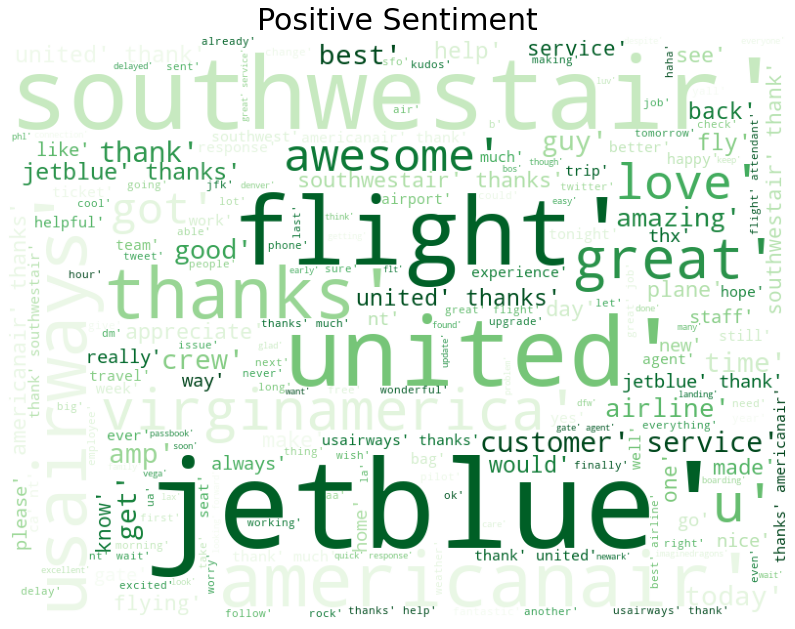

In [38]:
show_wordcloud(df_pos, "Positive Sentiment", 'Greens')

Common words: Thanks, love, great, nice, customer service, flight, Jetblue, various airlines

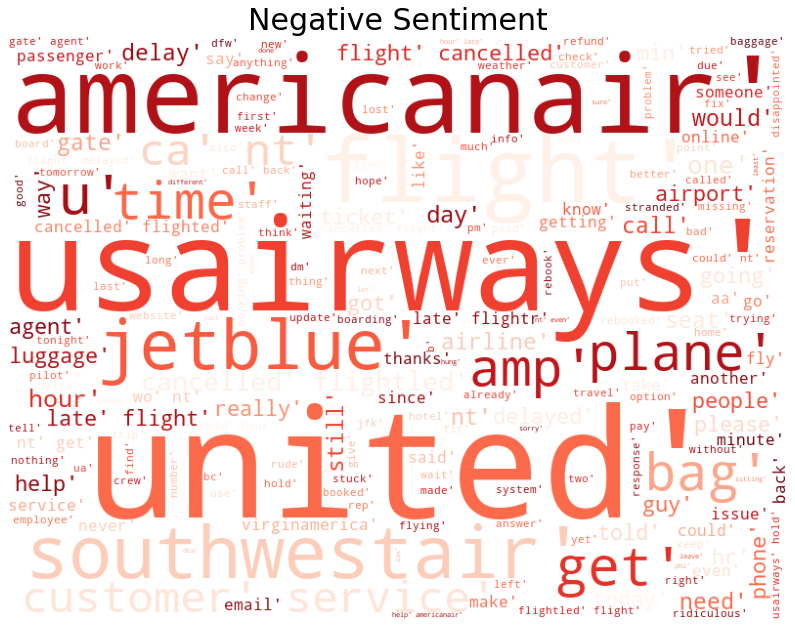

In [39]:
show_wordcloud(df_neg, "Negative Sentiment", 'Reds')

Common words: various airlines, cancelled, time, ticket, never, delayed

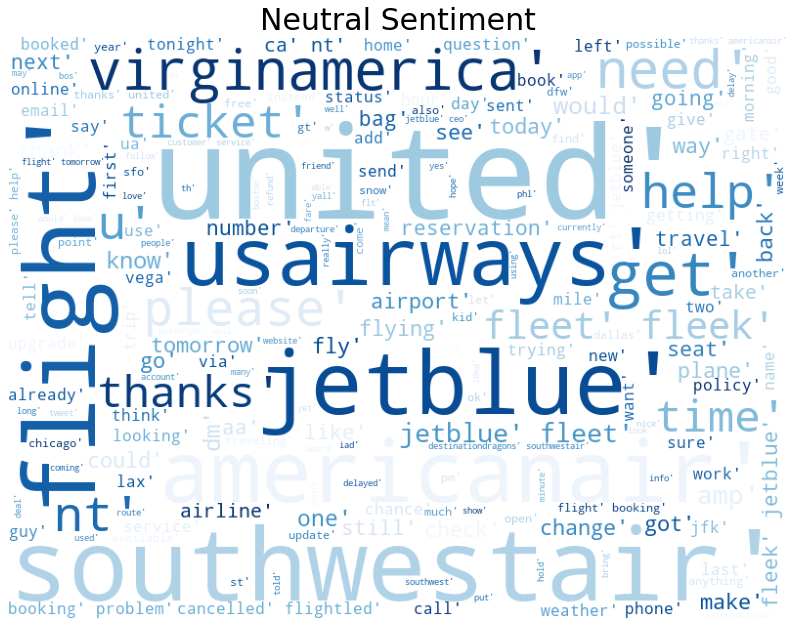

In [40]:
show_wordcloud(df_neu, "Neutral Sentiment", 'Blues')

Common words: Various airlines, need, fleet, like, think, get

# Vectorization

In [41]:
# Renormalizing the data to remove previous tokenization
df['text'] = df.apply(lambda row: normalize(row['text']), axis=1)

# Initializing the Vectorizer
vectorizer_BoW = CountVectorizer(max_features = 500)
vectorizer_Tfidf = TfidfVectorizer(max_features = 500)
data_features_BoW = vectorizer_BoW.fit_transform(df['text'])
data_features_Tf = vectorizer_Tfidf.fit_transform(df['text'])

# Converting data_features to an array
#data_features_BoW = data_features_BoW.toarray()
data_features_Tf = data_features_Tf.toarray()

# looking at the shape of the feature vector
print(data_features_BoW.shape, data_features_Tf.shape)

(14640, 500) (14640, 500)


# Model Building

## Count Vectorizer

In [42]:
# Replacing string data with numerical for machine learning
df.airline_sentiment.replace({'positive': 1, 'negative': 0, 'neutral': 2}, inplace = True)

# Defining the independant and dependant variables
X = data_features_BoW
y = df.airline_sentiment

# Splitting data into temporary and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# Splitting temporary into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=1, stratify=y_temp
)

# Checking shape of training, validation, and test data sets
print(X_train.shape, X_val.shape, X_test.shape)

(8198, 500) (3514, 500) (2928, 500)


In [43]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("Gradient", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("XGboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic", LogisticRegression(random_state=1, solver="newton-cg")))
models.append(("SGD", SGDClassifier(random_state=1, max_iter=1000, tol=1e-3)))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models
score = []  # Empty list to store score of the models

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Training Performance:" "\n")

for name, model in models:
    scoring = "accuracy"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    ) 
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = accuracy_score(y_val, model.predict(X_val))
    score.append(scores)
    print("{}: {}".format(name, scores))


Cross-Validation Training Performance:

Bagging: 70.35862884864358
Random Forest: 73.7862989032575
Gradient: 72.5297697882409
Adaboost: 72.96903971785295
XGboost: 71.39550439738687
dtree: 65.5527091176952
Logistic: 75.7013497224661
SGD: 75.1891620411018

Validation Performance:

Bagging: 0.7048947068867387
Random Forest: 0.7339214570290268
Gradient: 0.7347751849743882
Adaboost: 0.7327831531018782
XGboost: 0.7142857142857143
dtree: 0.6542401821286283
Logistic: 0.7623790552077405
SGD: 0.7663631189527604


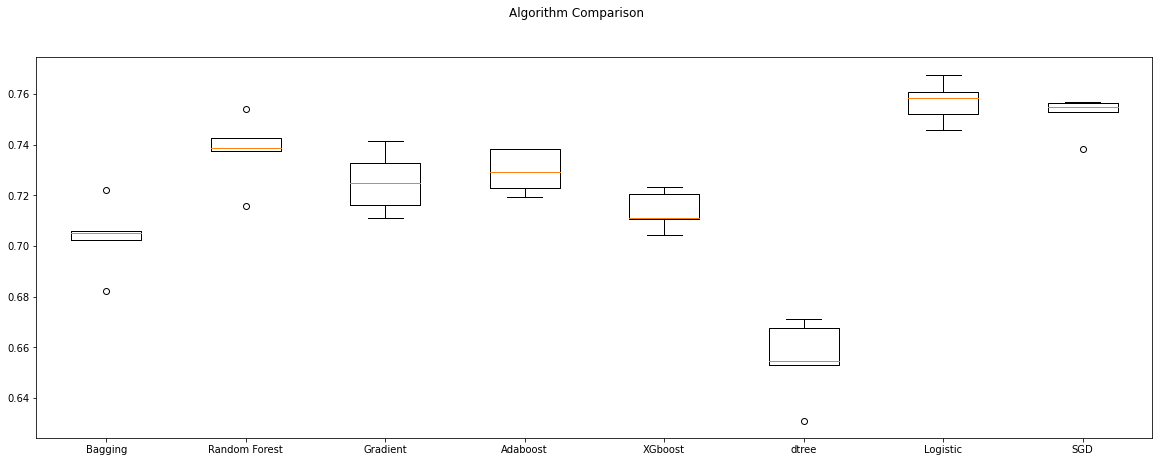

In [44]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(20, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

There are four distinct tiers:

1. Logistic and SGD with an average of 76% accuracy
2. Random Forest, Gradient, and Adaboost with an average of 73% accuracy
3. Bagging and XGBoost with an average of 71% accuracy
4. Decision Tree with an accuracy of 65%

The data is highly imbalanced. Lets see if we can even things out with SMOTE or RUS

In [45]:
# Saving for Word Cloud comparison
rf_bow = RandomForestClassifier(random_state=1)
rf_bow.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

### SMOTE and RUS

In [46]:
# Oversampling the training data
sampling_strategy = {0: 5140, 1: 3084, 2: 2570}
sm = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

# Undersampling the training data
sampling_strategy = 'not minority'
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

In [47]:
print("Before OverSampling, count of label '0': {} ".format(sum(y_train == 0)))
print("After OverSampling, count of label '0': {} \n".format(sum(y_train_over == 0)))

print("Before OverSampling, count of label '1': {}".format(sum(y_train == 1)))
print("After OverSampling, count of label '1': {} \n".format(sum(y_train_over == 1)))

print("Before OverSampling, count of label '2': {}".format(sum(y_train == 2)))
print("After OverSampling, count of label '2': {} ".format(sum(y_train_over == 2)))

Before OverSampling, count of label '0': 5140 
After OverSampling, count of label '0': 5140 

Before OverSampling, count of label '1': 1323
After OverSampling, count of label '1': 3084 

Before OverSampling, count of label '2': 1735
After OverSampling, count of label '2': 2570 


In [48]:
print("Before UnderSampling, count of label '0': {}".format(sum(y_train == 0)))
print("After UnderSampling, count of label '0': {} \n".format(sum(y_train_under == 0)))

print("Before UnderSampling, count of label '1': {}".format(sum(y_train == 1)))
print("After UnderSampling, count of label '1': {} \n".format(sum(y_train_under == 1)))

print("Before UnderSampling, count of label '2': {}".format(sum(y_train == 2)))
print("After UnderSampling, count of label '2': {}".format(sum(y_train_under == 2)))

Before UnderSampling, count of label '0': 5140
After UnderSampling, count of label '0': 1323 

Before UnderSampling, count of label '1': 1323
After UnderSampling, count of label '1': 1323 

Before UnderSampling, count of label '2': 1735
After UnderSampling, count of label '2': 1323


In [49]:
# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Training Performance:" "\n")

for name, model in models:
    scoring = "accuracy"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    ) 
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name + " SMOTE")
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = accuracy_score(y_val, model.predict(X_val))
    score.append(scores)
    print("{}: {}".format(name, scores))


Cross-Validation Training Performance:

Bagging: 70.20562672537872
Random Forest: 73.52228595859907
Gradient: 68.30650495951814
Adaboost: 68.31567836171708
XGboost: 71.89176415642261
dtree: 67.25031454424246
Logistic: 74.75441939489886
SGD: 74.70805443600746

Validation Performance:

Bagging: 0.6684689812179851
Random Forest: 0.6969265793966989
Gradient: 0.7379055207740467
Adaboost: 0.7134319863403529
XGboost: 0.7336368810472396
dtree: 0.6317586795674445
Logistic: 0.7398975526465567
SGD: 0.7501422879908936


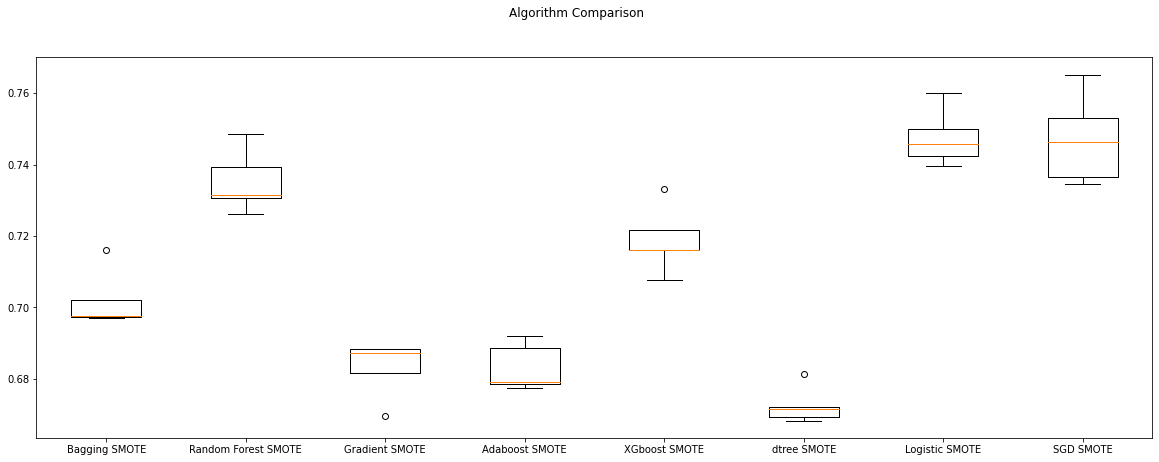

In [50]:
# Visualizing the Performance
fig = plt.figure(figsize=(20, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results[8:16])
ax.set_xticklabels(names[8:16])

plt.show()

- Logisitic and SGD are still the best models
- All other models are overfitting and performing worse
- SMOTE does not appear to have helped with the performance
  - There is likely a better way to implement SMOTE, but due to the time restrictions on this project this will need to be investigated at a later time.

In [51]:
# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Training Performance:" "\n")

for name, model in models:
    scoring = "accuracy"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    ) 
    cv_result = cross_val_score(
        estimator=model, X=X_train_under, y=y_train_under, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name + " RUS")
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_under, y_train_under)
    scores = accuracy_score(y_val, model.predict(X_val))
    score.append(scores)
    print("{}: {}".format(name, scores))


Cross-Validation Training Performance:

Bagging: 63.441797084692574
Random Forest: 67.32206555471205
Gradient: 67.69935931846986
Adaboost: 66.54047855765658
XGboost: 66.69208852014319
dtree: 58.83095473300701
Logistic: 69.91700045422637
SGD: 69.38806496390012

Validation Performance:

Bagging: 0.6459874786568014
Random Forest: 0.665907797381901
Gradient: 0.6832669322709163
Adaboost: 0.6442800227660785
XGboost: 0.6727376209447923
dtree: 0.5825270347182698
Logistic: 0.7006260671599317
SGD: 0.6980648833238474


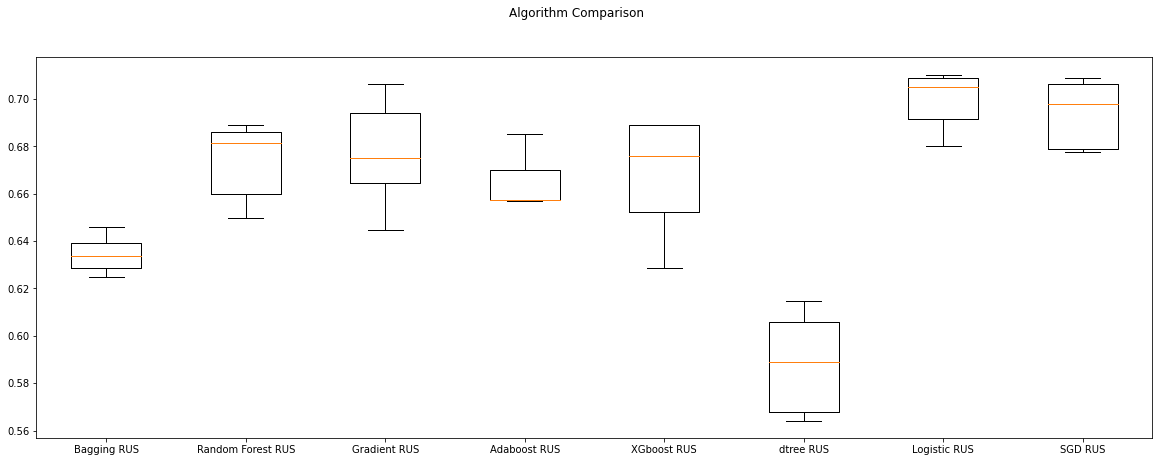

In [52]:
# Visualizing the Performance
fig = plt.figure(figsize=(20, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results[16:24])
ax.set_xticklabels(names[16:24])

plt.show()

Random Under Sampling has further reduced performance. All models performed best with the original data.

In [53]:
# Combining list of arrays into an array of means (each array is averaged into it's own mean)
results = np.array(results).mean(1)

# Creating seperate training data frames for each model
initial_model_train_perf = pd.Series(data=results[0:8])
initial_model_train_perf = pd.DataFrame(initial_model_train_perf)

smote_model_train_perf = pd.Series(data=results[8:16])
smote_model_train_perf = pd.DataFrame(smote_model_train_perf)

rus_model_train_perf = pd.Series(data=results[16:24])
rus_model_train_perf = pd.DataFrame(rus_model_train_perf)

# Combining the training validation data frames
base_model_train_perf = pd.concat(
    [initial_model_train_perf, smote_model_train_perf, rus_model_train_perf], axis=1,
)
# Labeling the index and columns appropriatly
base_model_train_perf.index = [
    "Bagging",
    "Random Forest",
    "Gradiant",
    "AdaBoost",
    "XGBoost",
    "dtree",
    "Logisitic",
    "SGD"
]
base_model_train_perf.columns = ["Base Model", "SMOTE", "RUS"]

print("Training performance comparison:")
base_model_train_perf.T

Training performance comparison:


,Bagging,Random Forest,Gradiant,AdaBoost,XGBoost,dtree,Logisitic,SGD
Base Model,0.703586,0.737863,0.725298,0.729690,0.713955,0.655527,0.757013,0.751892
SMOTE,0.702056,0.735223,0.683065,0.683157,0.718918,0.672503,0.747544,0.747081
RUS,0.634418,0.673221,0.676994,0.665405,0.666921,0.588310,0.699170,0.693881


In [54]:
# Creating seperate validation data frames for each model
initial_model_val_perf = pd.Series(data=score[0:8])
initial_model_val_perf = pd.DataFrame(initial_model_val_perf)

smote_model_val_perf = pd.Series(data=score[8:16])
smote_model_val_perf = pd.DataFrame(smote_model_val_perf)

rus_model_val_perf = pd.Series(data=score[16:24])
rus_model_val_perf = pd.DataFrame(rus_model_val_perf)

# Combining the individual validation data frames
base_model_val_perf = pd.concat(
    [initial_model_val_perf, smote_model_val_perf, rus_model_val_perf], axis=1
)
# Labeling the index and columns appropriatly
base_model_val_perf.index = [
    "Bagging",
    "Random Forest",
    "Gradiant",
    "AdaBoost",
    "XGBoost",
    "dtree",
    "Logisitic",
    "SGD"
]
base_model_val_perf.columns = ["Base Model", "SMOTE", "RUS"]

print("Validation performance comparison:")
base_model_val_perf.T

Validation performance comparison:


,Bagging,Random Forest,Gradiant,AdaBoost,XGBoost,dtree,Logisitic,SGD
Base Model,0.704895,0.733921,0.734775,0.732783,0.714286,0.654240,0.762379,0.766363
SMOTE,0.668469,0.696927,0.737906,0.713432,0.733637,0.631759,0.739898,0.750142
RUS,0.645987,0.665908,0.683267,0.644280,0.672738,0.582527,0.700626,0.698065


The Logisitic Regression and SGD Classifier had the best overall perfomance on the data set. Over and under sampling was attempted to combat the imbalance within the different sentiment classes but resulted in a reduction in performance for all models. Let's see if using Tf-IDF gives better results.

## TF-IDF Vectorizer

In [55]:
# Defining the independant and dependant variables
X = data_features_Tf
y = df.airline_sentiment

# Splitting data into temporary and testing sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

# Splitting temporary into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=1, stratify=y_temp
)

# Checking shape of training, validation, and test data sets
print(X_train.shape, X_val.shape, X_test.shape)

(8198, 500) (3514, 500) (2928, 500)


In [56]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random Forest", RandomForestClassifier(random_state=1)))
models.append(("Gradient", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("XGboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Logistic", LogisticRegression(random_state=1, solver="newton-cg")))
models.append(("SGD", SGDClassifier(random_state=1, max_iter=1000, tol=1e-3)))

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models
score = []  # Empty list to store score of the models

# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Training Performance:" "\n")

for name, model in models:
    scoring = "accuracy"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    ) 
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = accuracy_score(y_val, model.predict(X_val))
    score.append(scores)
    print("{}: {}".format(name, scores))


Cross-Validation Training Performance:

Bagging: 71.26138781827109
Random Forest: 74.29870236164227
Gradient: 74.06674206461406
Adaboost: 73.28625425973601
XGboost: 73.40810131103142
dtree: 66.46758136281791
Logistic: 76.11618476465424
SGD: 75.65262875935653

Validation Performance:

Bagging: 0.7083096186681844
Random Forest: 0.7421741605008537
Gradient: 0.7381900967558338
Adaboost: 0.730221969265794
XGboost: 0.7330677290836654
dtree: 0.6607854297097325
Logistic: 0.7692088787706317
SGD: 0.7726237905520774


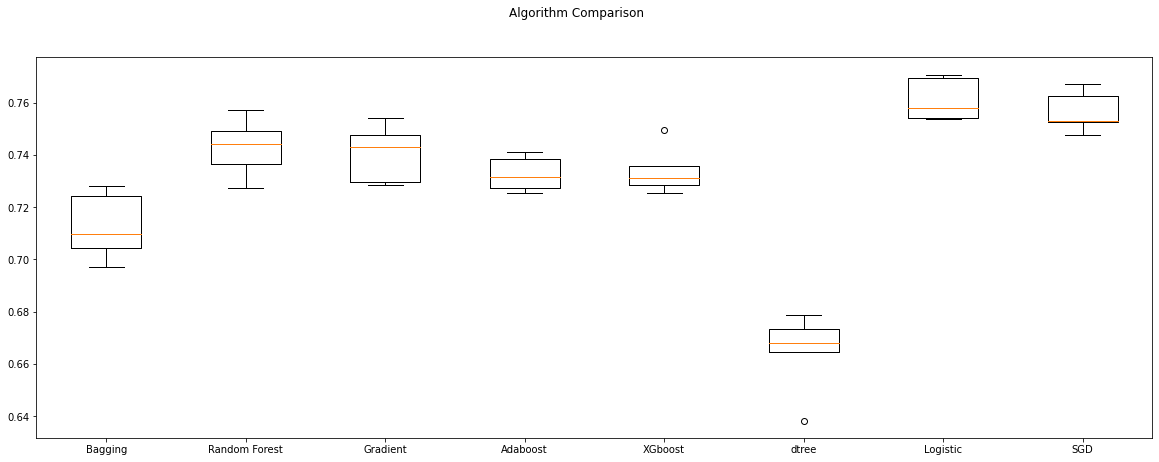

In [57]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure(figsize=(20, 7))

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

Logisitic Regression and SGD Classifier continue to perform the best out of the available machine learning models.

All other models have improved using the TF-IDF Vectorizer, but are still underperforming when compared to the logistic Regression and SGD Classifier.

# Model Evaluation

In [58]:
log_Tf = LogisticRegression(random_state=1, solver="newton-cg")
log_Tf.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='newton-cg')

In [59]:
# Viewing the classification report
result =  log_Tf.predict(X_test) 
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1835
           1       0.75      0.54      0.63       473
           2       0.65      0.49      0.56       620

    accuracy                           0.77      2928
   macro avg       0.73      0.65      0.68      2928
weighted avg       0.76      0.77      0.76      2928



0.75787109844981


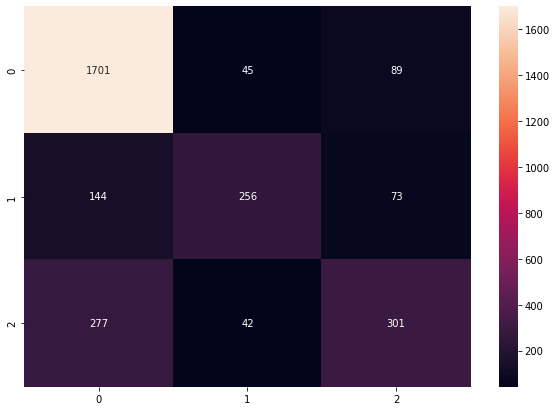

In [60]:
# Viewing the confusion matrix for Logistic Regression
 
conf_mat = confusion_matrix(y_test, result)

print(metrics.f1_score(y_test, result, average='weighted'))

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

The logistic regression is identifying the negative sentiment quite well. Positive sentiment is decently well predicted considering the imbalance within the data. Neutral statements have less than 50% accuracy and are not being predicted well.

In [61]:
SGD_Tf = SGDClassifier(random_state=1, max_iter=1000, tol=1e-3)
SGD_Tf.fit(X_train, y_train)

SGDClassifier(random_state=1)

In [62]:
# Viewing the classification report
result =  SGD_Tf.predict(X_test) 
print(classification_report(y_test, result))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      1835
           1       0.73      0.55      0.62       473
           2       0.65      0.49      0.56       620

    accuracy                           0.77      2928
   macro avg       0.73      0.65      0.68      2928
weighted avg       0.76      0.77      0.76      2928



0.7701502732240437


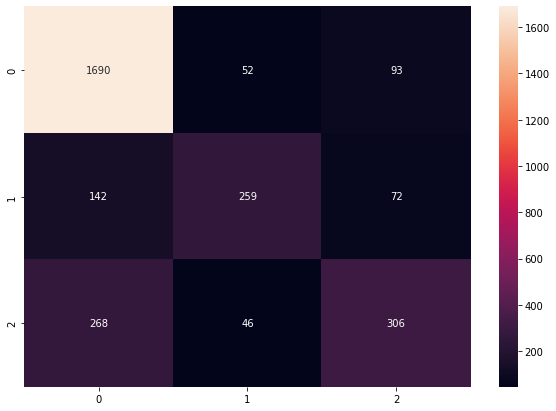

In [63]:
# Viewing the confusion matrix for SGD Classifier
conf_mat = confusion_matrix(y_test, result)

print(metrics.f1_score(y_test, result, average='micro'))

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

The SGD Classifier is slightly better at generalizing sentiments than the logistic regression. Both positive and neutral sentiment have seen a slight increase in accuracy while negative sentiment as fallen slightly.

## Word Cloud of Top 40 Features

Let's view the top 40 words for both Bag of Words and TF-IDF vectorizers. However, becasue logistic regression and SGD Classifier do not have the feature_importances function, we will use our second best performing model, Random Forest, for this comparison.

In [64]:
# Creating random forest model for TF-IDF
rf_tf = RandomForestClassifier(random_state=1)
rf_tf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


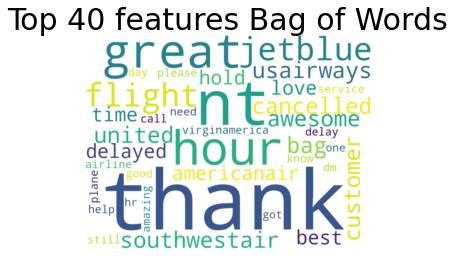

In [65]:
all_features = vectorizer_BoW.get_feature_names()                                #Instantiate the feature from the vectorizer
Top_features=''                                                              #Addition of top 40 feature into top_feature after training the model
feat=rf_bow.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    Top_features+=all_features[i]
    Top_features+=' '
    
  
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="White",width=1000, 
                          height=750).generate(Top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(30, 30), frameon='equal')
plt.title('Top 40 features Bag of Words', fontsize=30)
plt.axis("off")
plt.show();

Top words include: Thank, Great, Hour, Flight, Customer, and JetBlue

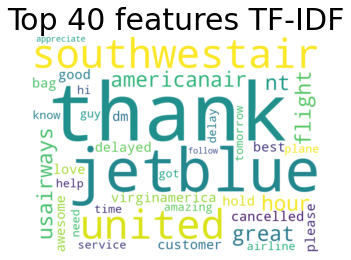

In [66]:
all_features = vectorizer_Tfidf.get_feature_names()                                #Instantiate the feature from the vectorizer
Top_features=''                                                              #Addition of top 40 feature into top_feature after training the model
feat=rf_tf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    Top_features+=all_features[i]
    Top_features+=' '
    
  
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="White",width=1000, 
                          height=750).generate(Top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(30, 30), frameon='equal')
plt.title('Top 40 features TF-IDF', fontsize=30)
plt.axis("off")
plt.show();

Top words include: Thank, Southwestair, United, JetBlue, AmericanAir, and Flight

# Conclusion and Key Insights

In this project a variety of different models were built using two different kinds of vectorization to create a NLP model for twitter sentiment analysis. Those models included bagging and boosting techniques, logisitic regression and SGD Classifiers, and random forest and decision trees. Ultimately, the best performing models for this data appear to be the Logistic Regression and SGD Classifier with a weighted F1 Score of 77% using the TF-IDF vectorizer.

While the Logistic Regression and SGD Classifier achieved similar scores, there were slight difference in the classification of sentiment for each model. The Logisitic Regression favored the majority class, negative sentiment, more and thus was not quite as good at generalizing. The SGD Classifier still favored the majority class, but appeared to be generalizing better to the test data and correctly identified more positive and neutral sentiments. For this reason, I would move forward with SGD Classifier for further model tuning and investigations.

During the analysis of the tweets some key insights were found. Those insights are as follows:
- Issues with Customer Service is the number one issue followed by delayed/late flights
- As one might expect, the majority of tweets were recieved during business hours and declined during the nighttime and morning hours
- Southwest and Delta receive a greater share of *positive* and *neutral* sentiment than other airlines in comparison to their overall tweet represenation
- United and US Airways recieve a greater share *negative* sentiment than other airlines in comparison to their overall tweet representation
- Thanks is the most common word in positive sentiment tweets
  - The two most common airlines are jetblue and southwest air
- flight is the most common word in negative sentiment tweets
  - The two most common airlines are united and usairways

Finally, model performance could likely be improved by the following:
- Determining a better way to either over or undersample to mitigate the imbalance within the dataset
- Implementing text augmentation in some way to make the model more generalizable
- Using more features during the vectorization process
- Hypertuning the parameters for the models
- Removing redundancies and duplicates within the tweets to reduce imbalance